In [9]:
import pytest
import numpy as np
import sys, os
import json
from pathlib import Path
import time

# sys.path.append(os.path.abspath(os.path.join('../..', 'examples')))
# from smart_em_script import get_microscope, get_get_rescan_map
import smartem
from smartem.smartem import SmartEM
from smartem.smartem_par import SmartEMPar
from smartem.online import microscope as microscope_client
from smartem.online import get_rescan_maps

from smartem.smartem_par import par_test

import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
repo_dir = Path("/Users/thomasathey/Documents/shavit-lab/smartem/SmartEM")
save_dir = "/Users/thomasathey/Desktop/temp"

In [3]:

# initializing fake random microscope
params = {"W": 1024, "H": 1024, "dtype": np.uint16}
microscope = microscope_client.FakeRandomMicroscope(params=params)

# initializing get_rescan_map
params = {"type": "half", "fraction": 0.5}
get_rescan_map = get_rescan_maps.GetRescanMapTest(params=params)
smart_em = SmartEM(microscope, get_rescan_map)

In [4]:

# initializing fake random microscope
params = {"W": 1024, "H": 1024, "dtype": np.uint16}
microscope = microscope_client.FakeRandomMicroscope(params=params)

# initializing get_rescan_map
params = {"type": "half", "fraction": 0.5}
get_rescan_map = get_rescan_maps.GetRescanMapTest(params=params)
smart_em_par = SmartEMPar(microscope, get_rescan_map)

In [5]:

with open(
    repo_dir / "examples/default_smartem_params.json",
    "r",
) as f:
    params = json.load(f)
    if "resolution" in params:
        params["resolution"] = tuple(params["resolution"])
    params["plot"] = False

with open(
    repo_dir / "examples/default_imaging_params.json",
    "r",
) as f:
    params_imaging = json.load(f)
    params.update(params_imaging)

# Don't acquire as many tiles as there will be sleeping involved
with open(
    repo_dir / "examples/default_imaging_params_short.json",
    "r",
) as f:
    params_imaging = json.load(f)
    params.update(params_imaging)

params["verbose"] = 0

smart_em.initialize()
smart_em_par.initialize()

In [6]:
data_total_times = []
data_task_times = []
data_method = []

smart_em.get_rescan_map.params["sleep_time"] = 0.5 # 2048x1768 pixels w/ 0.14 s/Mpx
smart_em_par.get_rescan_map.params["sleep_time"] = 0.5

params["sleep"] = True

for fast_dwt in tqdm([50e-9, 100e-9, 500e-9, 1000e-9]):
    for rep in tqdm(range(1), leave=False):
        params["fast_dwt"] = fast_dwt

        tic = time.time()
        smart_em.acquire_many_grids(
            coordinates=params["coordinates"], params=params, save_dir=save_dir
        )
        toc_serial = time.time()
        smart_em_par.acquire_many_grids(
            coordinates=params["coordinates"], params=params, save_dir=save_dir
        )
        toc_par = time.time()

        par_time = toc_par - toc_serial
        ser_time = toc_serial - tic
        print(f"{par_time} vs {ser_time}: {(ser_time-par_time)/ser_time*100}%")

        data_task_times.append(fast_dwt*5e6)
        data_total_times.append(par_time)
        data_method.append("Parallel")
        data_task_times.append(fast_dwt*5e6)
        data_total_times.append(ser_time)
        data_method.append("Serial")

data = {"Fast Imaging Time (s)": data_task_times, "Total Time (s)": data_total_times, "Method": data_method}
df = pd.DataFrame(data)


 25%|██▌       | 1/4 [00:29<01:27, 29.30s/it]

12.584275245666504 vs 16.71331000328064: 24.705068934900694%


 50%|█████     | 2/4 [01:03<01:04, 32.33s/it]

13.172980070114136 vs 21.273136138916016: 38.07692488736467%


 75%|███████▌  | 3/4 [02:50<01:06, 66.10s/it]

49.1606171131134 vs 57.11487293243408: 13.92676795189657%


100%|██████████| 4/4 [06:06<00:00, 91.58s/it] 

94.14517092704773 vs 102.12448692321777: 7.813322971374424%


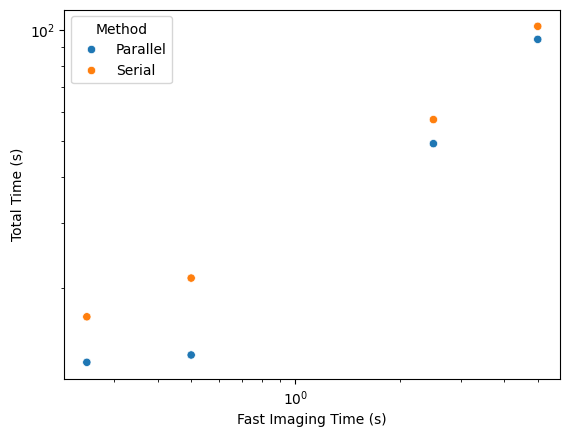

In [12]:
sns.scatterplot(df, x="Fast Imaging Time (s)", y="Total Time (s)", hue="Method")
plt.xscale('log')
plt.yscale('log')